# SPXNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data_sp500_datahub = pd.read_csv("/content/drive/MyDrive/Tfg21DB/data/data_SPX_datahub.csv")
data_sp500_yahoo = pd.read_csv("/content/drive/MyDrive/Tfg21DB/data/data_SPX_yahoo.csv")

# Data Extraction
In this section we will obtain the data that will later be used not only to build and train our neural networks, but also to test their efectiveness (or lack thereof) in predicting indexes in short and short-medium term. We will focus on an index price, but also on other widely aspects of an index or the companies forming it, such as dividends, earnings, P/E ratio, etc.

In [1]:
%%capture
pip install datapackage;

In [2]:
import datapackage
import pandas as pd

data_url = 'https://datahub.io/core/s-and-p-500/datapackage.json'

# to load Data Package into storage
package = datapackage.Package(data_url)

# to load only tabular data
resources = package.resources
data = []
for resource in resources:
    if resource.tabular:
        data.append(pd.read_csv(resource.descriptor['path']))
data_sp500index_datahub = data[0]

In [8]:
data_sp500index_datahub.sample(5)

,Date,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10
132,1882-01-01,5.92,0.32,0.44,10.18,3.62,145.28,7.85,10.78,15.68
1724,2014-09-01,1993.23,38.49,105.96,238.03,2.53,2092.08,40.40,111.21,25.92
835,1940-08-01,10.20,0.66,1.07,14.00,2.06,182.02,11.84,19.04,13.65
256,1892-05-01,5.57,0.23,0.35,7.04,3.65,197.65,8.10,12.51,19.91
1744,2016-05-01,2065.55,44.27,86.76,240.23,1.81,2148.15,46.04,90.23,25.69


## Different way of extracting data
We can also get the data about the S&P500 and it's companies stock valuation by using the yfinance github.

In [9]:
import pandas_datareader as web
from datetime import datetime as date
import requests
import io

def fetch_yahoo(stock_symbol, date_start, date_end):
  headers = {
      'User-Agent': 'Mozilla/5.0'
  }

  url = "https://query1.finance.yahoo.com/v7/finance/download/"
  url += str(stock_symbol) #Add stock simbol to url
  x = int(date.strptime(date_start, '%Y-%m-%d').strftime("%s"))
  y = int(date.strptime(date_end, '%Y-%m-%d').strftime("%s"))
  url += "?period1=" + str(x) + "&period2=" + str(y) + \
      "&interval=1d&events=history&includeAdjustedClose=true"

  r = requests.get(url, headers=headers)
  pds = pd.read_csv(io.StringIO(r.text), index_col=0, parse_dates=True)
  

  return pds

In [12]:
#Now we set the variables concerning the company we want to look at, as well as,
#the range of dates between we will look.
stock_symbol = 'TSLA'

data_yahoo = fetch_yahoo(stock_symbol, date_start="2018-01-01", date_end="2021-01-01")
print(data_yahoo)

                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2018-01-02   62.400002   64.421997  ...   64.106003  21761000
2018-01-03   64.199997   65.050003  ...   63.450001  22607500
2018-01-04   62.574001   63.709999  ...   62.924000  49731500
2018-01-05   63.324001   63.448002  ...   63.316002  22956000
2018-01-08   63.200001   67.403999  ...   67.281998  49297000
...                ...         ...  ...         ...       ...
2020-12-24  642.989990  666.090027  ...  661.770020  22865600
2020-12-28  674.510010  681.400024  ...  663.690002  32278600
2020-12-29  661.000000  669.900024  ...  665.989990  22910800
2020-12-30  672.000000  696.599976  ...  694.780029  42846000
2020-12-31  699.989990  718.719971  ...  705.669983  49649900

[756 rows x 6 columns]


In [11]:
#Now we set the variables concerning the company we want to look at, as well as,
#the range of dates between we will look.
stock_symbol = 'FB'

dataFB = fetch_yahoo(stock_symbol, date_start="2018-01-01", date_end="2021-01-01")
print(data_yahoo)

                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2018-01-02  177.679993  181.580002  ...  181.419998  18151900
2018-01-03  181.880005  184.779999  ...  184.669998  16886600
2018-01-04  184.899994  186.210007  ...  184.330002  13880900
2018-01-05  185.589996  186.899994  ...  186.850006  13574500
2018-01-08  187.199997  188.899994  ...  188.279999  17994700
...                ...         ...  ...         ...       ...
2020-12-24  268.880005  270.399994  ...  267.399994   6702000
2020-12-28  268.739990  277.299988  ...  277.000000  23299700
2020-12-29  276.950012  280.510010  ...  276.779999  16383000
2020-12-30  277.950012  278.079987  ...  271.869995  11803800
2020-12-31  272.000000  277.089996  ...  273.160004  12900400

[756 rows x 6 columns]


# DATA PREPARATION
In this notebook we will take care of all the necessary preparation of data, like selecting the aspects of our datasets that we want to look into, scaling the data, etc.


In [13]:
import pandas as p
import numpy as np

In [14]:
print(data_yahoo)

                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2018-01-02   62.400002   64.421997  ...   64.106003  21761000
2018-01-03   64.199997   65.050003  ...   63.450001  22607500
2018-01-04   62.574001   63.709999  ...   62.924000  49731500
2018-01-05   63.324001   63.448002  ...   63.316002  22956000
2018-01-08   63.200001   67.403999  ...   67.281998  49297000
...                ...         ...  ...         ...       ...
2020-12-24  642.989990  666.090027  ...  661.770020  22865600
2020-12-28  674.510010  681.400024  ...  663.690002  32278600
2020-12-29  661.000000  669.900024  ...  665.989990  22910800
2020-12-30  672.000000  696.599976  ...  694.780029  42846000
2020-12-31  699.989990  718.719971  ...  705.669983  49649900

[756 rows x 6 columns]


In [18]:
data_yahoo.shape
data_yahoo.sample(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-06,55.296001,56.301998,54.877998,55.248001,55.248001,51677500
2020-02-24,167.800003,172.699997,164.440002,166.757996,166.757996,75961000
2018-10-17,56.480000,56.540001,53.160000,54.355999,54.355999,43277500
2018-04-24,57.000000,57.417999,55.692001,56.692001,56.692001,28426500
2020-04-29,158.033997,160.639999,156.632004,160.102005,160.102005,81080000


Now we want to discard some of the features of our DataFrame, because the neural network will be trained to predict exactly 1. So for example we will only look into the **closing value** of the S&P500 Index.

In [19]:
data_closing_value = data_yahoo['Close']
data_closing_value = data_closing_value.values.reshape(-1,1)

## DATA SCALING
Now we will scale the data in order to improve how our model will be able to learn from the given train datasets.


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_closing = scaler.fit_transform(data_closing_value)
print(scaled_data_closing)

In [22]:
#This variable is the number of 'previous' days that we will use to train our model
prediction_days = 60

if len(scaled_data_closing) < prediction_days:
  prediction_days = len(scaled_data_closing)

In [23]:
prediction_days

60

## Preparing the Train and Test datasets

Now, in order to train our database we have to fill up the *x_train* and *y_train* subsets which contain the independent and dependent variables respectively.

*  *prediction_days*: number of days we want to take into account for the estimation of each days closing value.

So we will iterate over all the days which have more than *#prediction_days* of days "behind" them in ourdataset, and for each day *d* in that subset, we will add to the train subsets the following.

*   *x_train*: we save a vector consisting of the *prediction_days* previous days closing values' to the *d* day (Independent Variables)
*   *y_train*: the dependent variable which we want to learn how to estimate, which is the closing value of S&P500 for the *d* day (Dependent Variable)




In [ ]:
#prediction_days=60

In [ ]:
x_train = []
y_train = []

for d in range(prediction_days, len(scaled_data_closing)):
  #vector consisting of the previous days of an observation
  prev_data = scaled_data_closing[d-prediction_days:d, 0]
  x_train.append(prev_data)
  y_train.append(scaled_data_closing[d,0])

#Now we turn x_train and y_train into numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
#print(x_train)

In [ ]:
x_train, y_train

In [26]:
x_train.shape, y_train.shape

((696, 60, 1), (696,))

## BUILDING THE MODEL
Now we will build the neural network model using LSTM and Dropout layers, as well as a final Dense layer with only 1 unit in order to get the price prediction that our model outputs.

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [ ]:
nh1=50
nh2=50

In [ ]:
nh1=[1,2,4,8,16,32,64]

In [30]:
model = Sequential()

model.add(LSTM(units = nh2, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=40)

Epoch 1/25
18/18 [==============================] - 10s 152ms/step - loss: 0.0229
Epoch 2/25
18/18 [==============================] - 3s 154ms/step - loss: 0.0045
Epoch 3/25
18/18 [==============================] - 3s 149ms/step - loss: 0.0038
Epoch 4/25
18/18 [==============================] - 2s 91ms/step - loss: 0.0024
Epoch 5/25
18/18 [==============================] - 2s 91ms/step - loss: 0.0022
Epoch 6/25
18/18 [==============================] - 2s 93ms/step - loss: 0.0026
Epoch 7/25
18/18 [==============================] - 2s 93ms/step - loss: 0.0022
Epoch 8/25
18/18 [==============================] - 2s 91ms/step - loss: 0.0024
Epoch 9/25
18/18 [==============================] - 2s 92ms/step - loss: 0.0028
Epoch 10/25
18/18 [==============================] - 2s 129ms/step - loss: 0.0022
Epoch 11/25
18/18 [==============================] - 2s 126ms/step - loss: 0.0024
Epoch 12/25
18/18 [==============================] - 3s 150ms/step - loss: 0.0024
Epoch 13/25
18/18 [===========

## Testing Model Accuracy
Now we test the model's accuracy on data the model hasn't seen before, so data from the end date of the training data up until the present day.

In [31]:
#Extract the testing data
start_data = "2021-01-01"
end_data = date.now().strftime("%Y-%m-%d")

test_data = fetch_yahoo("TSLA", date_start=start_data, date_end=end_data)
test_price = test_data['Close'].values

total_dataset = pd.concat((data_yahoo['Close'], test_data['Close']), axis=0)

model_input = total_dataset[len(total_dataset) - len(test_data) - prediction_days:]
model_input = model_input.values
model_input = model_input.reshape(-1,1)
model_input = scaler.transform(model_input)

x_test = []

for d in range(prediction_days, len(model_input)):
  #vector consisting of the previous days of an observation
  prev_data = model_input[d-prediction_days:d, 0]
  x_test.append(prev_data)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [32]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
np.shape(predicted_prices)

(273, 1)

## PLOTTING THE PREDICTION
After feeding our model the totaldataset we will get a function of the predicted price, we will plot it against the actual prices to get a better view of the prediction we are making

Text(0, 0.5, 'TSLA')

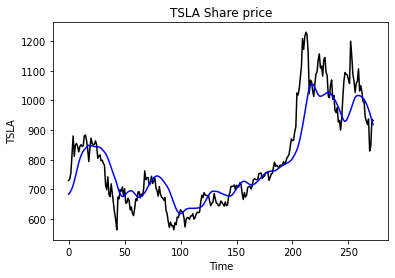

In [33]:
import matplotlib.pyplot as plt

plt.plot(test_price, color = "black", label=f"Actual Price for {stock_symbol}")
plt.plot(predicted_prices, color = "blue", label=f"Prediciton")
plt.title(f"{stock_symbol} Share price")
plt.xlabel("Time")
plt.ylabel(f"{stock_symbol}")

## PREDICT NEXT DAY

In [ ]:
real_data = [model_input[len(model_input) - prediction_days:len(model_input)+1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

price_prediction = model.predict(real_data)
price_prediction = scaler.inverse_transform(price_prediction)
print(f"Prediction: {price_prediction} for the day {end_data}")

Prediction: [[913.9471]] for the day 2022-02-01


In [ ]:
k_step = 10
starting_day = 100

pred_k_prices = model.predict(x_test[starting_day-prediction_days:starting_day+1])
pred_k_prices = scaler.inverse_transform(pred_k_prices)
print(pred_k_prices)



## TRYING ANOTHER MODEL

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import activations
from tensorflow.keras import initializers

model = Sequential()

model.add(LSTM(units = 50, activation = activations.relu, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, activation = activations.relu, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, activation = activations.relu))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=40)

Epoch 1/25
18/18 [==============================] - 9s 128ms/step - loss: 0.0514
Epoch 2/25
18/18 [==============================] - 2s 92ms/step - loss: 0.0117
Epoch 3/25
18/18 [==============================] - 2s 94ms/step - loss: 0.0059
Epoch 4/25
18/18 [==============================] - 2s 91ms/step - loss: 0.0044
Epoch 5/25
18/18 [==============================] - 2s 94ms/step - loss: 0.0033
Epoch 6/25
18/18 [==============================] - 2s 91ms/step - loss: 0.0027
Epoch 7/25
18/18 [==============================] - 2s 92ms/step - loss: 0.0031
Epoch 8/25
18/18 [==============================] - 2s 90ms/step - loss: 0.0038
Epoch 9/25
18/18 [==============================] - 2s 90ms/step - loss: 0.0029
Epoch 10/25
18/18 [==============================] - 2s 89ms/step - loss: 0.0025
Epoch 11/25
18/18 [==============================] - 2s 90ms/step - loss: 0.0028
Epoch 12/25
18/18 [==============================] - 2s 91ms/step - loss: 0.0032
Epoch 13/25
18/18 [=================

ANOTHER MODEL

In [ ]:
from tensorflow.keras.layers import SimpleRNN

#For this model we don't need the x_train and y_train reshaped so

In [39]:
recurrent_model = Sequential()

recurrent_model.add(SimpleRNN(units = 50, activation = "relu",return_sequences=True, input_shape=(x_train.shape[1], 1)))
recurrent_model.add(SimpleRNN(units = 50, activation = "relu"))
recurrent_model.add(Dense(units = 1))

recurrent_model.compile(optimizer="adam", loss='mean_squared_error')
recurrent_model.fit(x_train, y_train, epochs = 25, batch_size= 25)

Epoch 1/25
28/28 [==============================] - 2s 25ms/step - loss: 0.0716
Epoch 2/25
28/28 [==============================] - 1s 24ms/step - loss: 0.0011
Epoch 3/25
28/28 [==============================] - 1s 24ms/step - loss: 4.6367e-04
Epoch 4/25
28/28 [==============================] - 1s 24ms/step - loss: 4.0436e-04
Epoch 5/25
28/28 [==============================] - 1s 24ms/step - loss: 4.3019e-04
Epoch 6/25
28/28 [==============================] - 1s 29ms/step - loss: 3.7489e-04
Epoch 7/25
28/28 [==============================] - 1s 42ms/step - loss: 3.3452e-04
Epoch 8/25
28/28 [==============================] - 1s 38ms/step - loss: 3.5427e-04
Epoch 9/25
28/28 [==============================] - 1s 42ms/step - loss: 3.2996e-04
Epoch 10/25
28/28 [==============================] - 1s 44ms/step - loss: 3.2262e-04
Epoch 11/25
28/28 [==============================] - 1s 45ms/step - loss: 3.2692e-04
Epoch 12/25
28/28 [==============================] - 1s 38ms/step - loss: 3.2745e-

In [40]:
predicted_prices_r = recurrent_model.predict(x_test)
np.shape(predicted_prices_r)
predicted_prices_r = scaler.inverse_transform(predicted_prices_r)


Text(0, 0.5, 'TSLA')

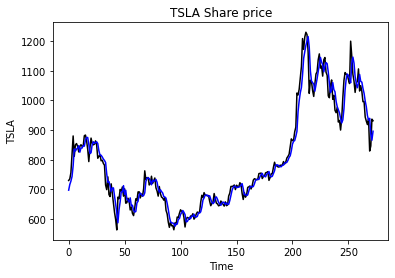

In [44]:
plt.plot(test_price, color = "black", label=f"Actual Price for {stock_symbol}")
plt.plot(predicted_prices_r, color = "blue", label=f"Prediciton")
plt.title(f"{stock_symbol} Share price")
plt.xlabel("Time")
plt.ylabel(f"{stock_symbol}")

PREDICTING K-STEPS AHEAD OF A DAY IN THE TEST DATASET